In [30]:
import boto3
import os

# from sagemaker import get_execution_role, Session

# # Initialize a SageMaker session
# sagemaker_session = Session()

# role = "arn:aws:iam::016114370410:role/tf-binding-sites"

# prefix = "tf-binding-sites/inference/input"
# local_dir = "/Users/wejarrard/projects/tf-binding/data/jsonl"

# # Initialize the S3 client
# s3 = boto3.client('s3')

# # Specify your S3 bucket name
# bucket_name = sagemaker_session.default_bucket()


# # Function to download files from an S3 bucket
# def download_from_s3(bucket_name, prefix, local_dir):
#     if not os.path.exists(local_dir):
#         os.makedirs(local_dir)

#     # List objects within the specified prefix
#     response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

#     # Iterate over each object
#     for obj in response.get('Contents', []):
#         key = obj['Key']
#         # Skip if it's a folder
#         if key.endswith('/'):
#             continue
#         local_path = os.path.join(local_dir, os.path.basename(key))
        
#         # Download the file
#         s3.download_file(bucket_name, key, local_path)
#         print(f'Downloaded {key} to {local_path}')

# # Bucket name extracted from the S3 URI
# bucket_name = "tf-binding-sites"

# prefix = "inference/output"

# # Download the files
# download_from_s3(bucket_name, prefix, "/Users/wejarrard/projects/tf-binding/data/jsonl_output")

In [31]:
import pandas as pd
import glob

# Path to the directory containing JSON files
json_dir = "/Users/wejarrard/projects/tf-binding/data/jsonl_output"

# Get a list of all JSON files in the directory
json_files = glob.glob(f"{json_dir}/*.jsonl.gz.out")

# Read each JSON file into a DataFrame and store in a list
dataframes = [pd.read_json(file) for file in json_files]

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

df

# # precision and recall
df['tp'] = (df['targets'] == 1) & (df['predicted'] == 1)
df['fp'] = (df['targets'] == 0) & (df['predicted'] == 1)
df['fn'] = (df['targets'] == 1) & (df['predicted'] == 0)
df['tn'] = (df['targets'] == 0) & (df['predicted'] == 0)

precision = df['tp'].sum() / (df['tp'].sum() + df['fp'].sum())
recall = df['tp'].sum() / (df['tp'].sum() + df['fn'].sum())

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# f1 score
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 score: {f1:.2f}")

# accuracy
accuracy = (df['tp'].sum() + df['tn'].sum()) / len(df)
print(f"Accuracy: {accuracy:.2f}")


Precision: 0.00
Recall: 0.40
F1 score: 0.01
Accuracy: 0.99


In [32]:
print(f"False positives: {df['fp'].sum()}")
print(f"False negatives: {df['fn'].sum()}")
print(f"True positives: {df['tp'].sum()}")
print(f"True negatives: {df['tn'].sum()}")

False positives: 564
False negatives: 3
True positives: 2
True negatives: 67388


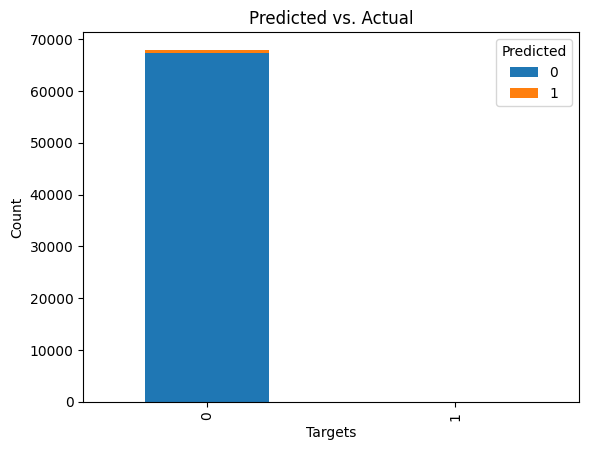

In [33]:
# Graph number of true positives, false positives, true negatives, and false negatives
import matplotlib.pyplot as plt

# Group by the 'targets' and 'predicted' columns
grouped = df.groupby(['targets', 'predicted']).size().unstack()

# Plot the grouped data
grouped.plot(kind='bar', stacked=True)
plt.xlabel('Targets')
plt.ylabel('Count')
plt.title('Predicted vs. Actual')
plt.legend(title='Predicted')

plt.show()

# Plot the ROC curve

In [34]:
# filter out for false positives
df_fp = df[df['fp'] == True]

# get average probability for false positives
avg_prob_fp = df_fp['probabilities'].mean()
print(f"Average probability for false positives: {avg_prob_fp:.2f}")
print(f"Number of false positives: {len(df_fp)}")

Average probability for false positives: 0.78
Number of false positives: 564


In [35]:
# Average probability for true positives
df_tp = df[df['tp'] == True]
avg_prob_tp = df_tp['probabilities'].mean()
print(f"Average probability for true positives: {avg_prob_tp:.2f}")

Average probability for true positives: 0.95


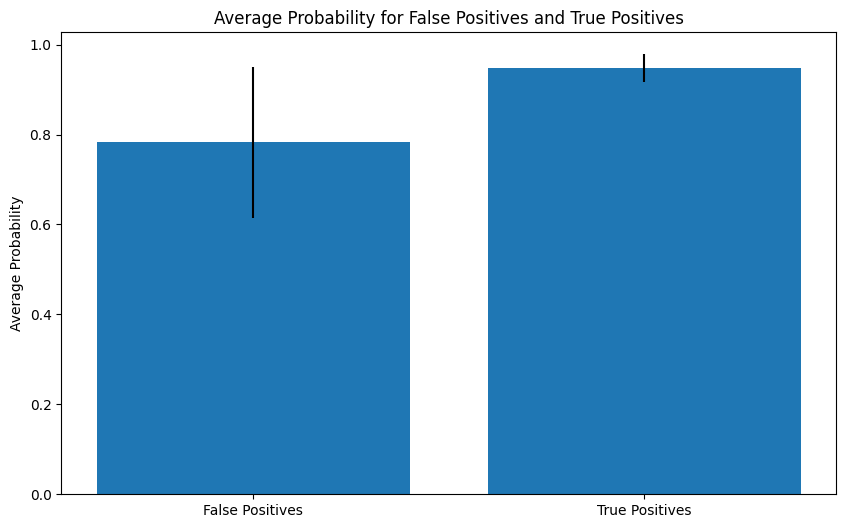

In [36]:
import matplotlib.pyplot as plt

# Show bar plots with false positives and true positives and thier std
plt.figure(figsize=(10, 6))
plt.bar(['False Positives', 'True Positives'], [avg_prob_fp, avg_prob_tp], yerr=[df_fp['probabilities'].std(), df_tp['probabilities'].std()])
plt.ylabel('Average Probability')
plt.title('Average Probability for False Positives and True Positives')
plt.show()

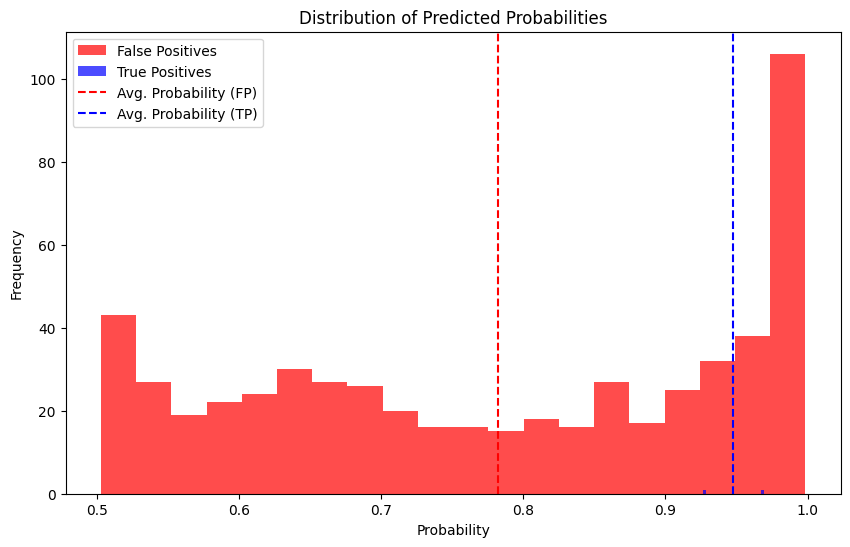

In [37]:
# graph with std dev

# Plot the distribution of probabilities for false positives
plt.figure(figsize=(10, 6))
plt.hist(df_fp['probabilities'], bins=20, color='red', alpha=0.7, label='False Positives')
plt.hist(df_tp['probabilities'], bins=20, color='blue', alpha=0.7, label='True Positives')
plt.axvline(avg_prob_fp, color='red', linestyle='--', label='Avg. Probability (FP)')
plt.axvline(avg_prob_tp, color='blue', linestyle='--', label='Avg. Probability (TP)')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()

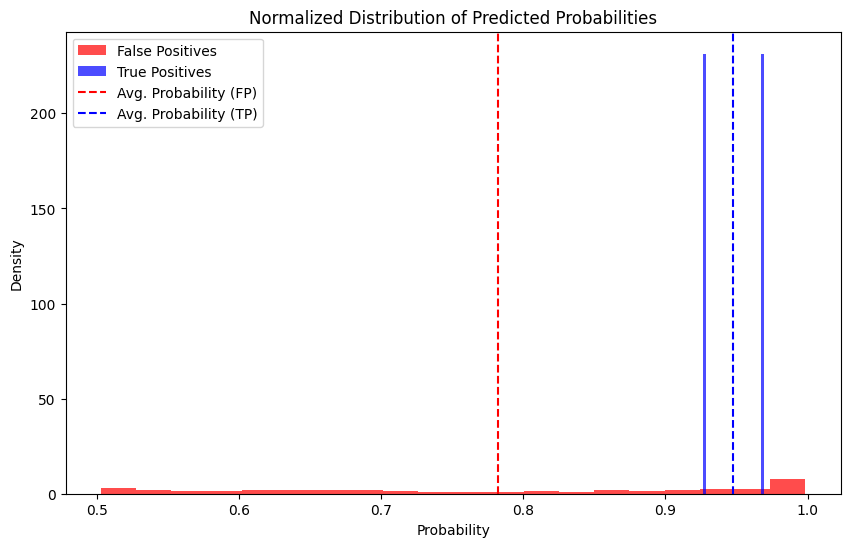

In [38]:
import matplotlib.pyplot as plt

# Normalize histograms by setting density=True
plt.figure(figsize=(10, 6))
plt.hist(df_fp['probabilities'], bins=20, color='red', alpha=0.7, label='False Positives', density=True)
plt.hist(df_tp['probabilities'], bins=20, color='blue', alpha=0.7, label='True Positives', density=True)
plt.axvline(avg_prob_fp, color='red', linestyle='--', label='Avg. Probability (FP)')
plt.axvline(avg_prob_tp, color='blue', linestyle='--', label='Avg. Probability (TP)')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Normalized Distribution of Predicted Probabilities')
plt.legend()
plt.show()